# 自然言語処理

IMDB映画レビューデータセットの準備

ダウンロード

In [2]:
# IMDBをカレントフォルダにダウンロード
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# 解凍
!tar zxf aclImdb_v1.tar.gz
# aclImdb/train/unsupはラベル無しのため削除
!rm -rf aclImdb/train/unsup
# IMDBデータセットの説明を表示
!cat aclImdb/README


--2021-09-16 08:55:05--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  12.2MB/s    in 7.5s    

2021-09-16 08:55:13 (10.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an a

読み込み

In [3]:
from sklearn.datasets import load_files
train_review = load_files('./aclImdb/train/', encoding='utf-8')
x_train, y_train = train_review.data, train_review.target
test_review = load_files('./aclImdb/test/', encoding='utf-8')
x_test, y_test = test_review.data, test_review.target
# ラベルの0,1と意味の対応の表示
print(train_review.target_names)

['neg', 'pos']


このデータセットについて

In [4]:
print("x : {}".format(x_train[0]))

x : Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.


### BoW

In [5]:
mini_dataset = \
  ["This movie is very good.",
  "This film is a good",
  "Very bad. Very, very bad."]

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b')
bow = (vectorizer.fit_transform(mini_dataset)).toarray()
# DataFrameにまとめる
df = pd.DataFrame(bow, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,is,movie,this,very
0,0,0,0,1,1,1,1,1
1,1,0,1,1,1,0,1,0
2,0,2,0,0,0,0,0,3


In [7]:
# ngram_rangeで利用するn-gramの範囲を指定する
vectorizer = CountVectorizer(ngram_range=(2, 2), token_pattern=r'(?u)\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)


,a good,bad very,film is,is a,is very,movie is,this film,this movie,very bad,very good,very very
0,0,0,0,0,1,1,0,1,0,1,0
1,1,0,1,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,1


In [8]:
# ライブラリのインポート
from sklearn.datasets import load_files
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from gensim.models import word2vec
import numpy as np
from sklearn.preprocessing import normalize
import re


# 【問題1】BoWのスクラッチ実装

## 1-gram

In [9]:
dataset = \
  ["This movie is SOOOO funny!!!",
  "What a movie I never",
  "best movie ever!!!!! this movie"]

In [10]:
def bow(data):
  """
  bowの算出
  --------
  data: 文章リスト
  """
  ## 単語リスト作成
  # 「!」 除去
  # 文字列を半角スペースで分割、リスト化
  row_data = [i.lower().replace('!','').split(' ') for i in data]
  #print(row_data)

  # 1次元のリストにする
  feature_names = set(list(itertools.chain.from_iterable(row_data)))
  #print(feature_names)

  # bow計算
  bow = []

  # １つずつ文章でループ
  for index,row in enumerate(data):
    bow.append([])
    # 単語リストでループ
    for feature_name in feature_names:
      # 何個含まれているか
      num = row_data[index].count(feature_name)
      #print(num)
      # 追加
      bow[index].append(num)
      #print(bow)
  return feature_names,bow

In [11]:
# bow関数実行
feature_names,bow = bow(dataset)

In [12]:
# DF化
df = pd.DataFrame(bow,columns=feature_names)

In [13]:
# 出力
display(df)

,soooo,never,i,this,best,funny,movie,is,ever,what,a
0,1,0,0,1,0,1,1,1,0,0,0
1,0,1,1,0,0,0,1,0,0,1,1
2,0,0,0,1,1,0,2,0,1,0,0


In [14]:
# hoge =[['this', 'movie', 'is', 'soooo', 'funny'],
#        ['what', 'a', 'movie', 'i', 'never'],
#        ['best', 'movie', 'ever', 'this', 'movie']]


In [15]:
# print(hoge[0][0])
# print(hoge[0][1])
# print(len(hoge[0]) - 1)

In [16]:
#print(hoge[0][0] +" " + hoge[0][1])

## 2-gram

In [17]:
def bow2(data):
  ## 単語リスト作成
    # 小文字に統一
    # !除去
  # 文字列を半角スペース基準で分割し、リスト化
  bow_list =[]
  row_data = [i.lower().replace('!', '').split(' ') for i in data]
  for j in range(len(row_data)):
    bow_list.append([])
    for i in range(len(row_data[0]) - 1):
      bow_list[j].append(row_data[j][i] + " " + row_data[j][i + 1])

  # 1次元のリストに(単語リスト)
  feature_names = set(list(itertools.chain.from_iterable(bow_list)))

  ## bow計算
  bow = []
  # 1つづつ文章でループ
  for index,row in enumerate(bow_list):
      bow.append([])
      # 単語リストでループ
      for feature_name in feature_names:
          # 何個含まれているか
          num = bow_list[index].count(feature_name)
          # 追加
          bow[index].append(num)

  return feature_names,bow

In [18]:
# bow関数実行
f_name,bow2 = bow2(dataset)

In [19]:
# DF化
df2 = pd.DataFrame(bow2, columns=f_name)

In [20]:
# 出力
display(df2)

,this movie,movie i,movie is,is soooo,best movie,a movie,what a,movie ever,ever this,i never,soooo funny
0,1,0,1,1,0,0,0,0,0,0,1
1,0,1,0,0,0,1,1,0,0,1,0
2,1,0,0,0,1,0,0,1,1,0,0


# 【問題2】TF-IDFの計算

IMDB映画レビューデータセットをTF-IDFによりベクトル化してください。NLTKのストップワードを利用し、最大の語彙数は5000程度に設定してください。テキストクリーニングやステミングなどの前処理はこの問題では要求しません。



IDF

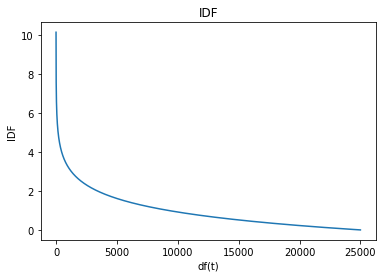

In [21]:
import numpy as np
import matplotlib.pyplot as plt
n_samples = 25000
idf = np.log(n_samples/np.arange(1,n_samples))
plt.title("IDF")
plt.xlabel("df(t)")
plt.ylabel("IDF")
plt.plot(idf)
plt.show()

ストップワード

あまりにも頻繁に登場するトークンは、値を小さくするだけでなく、取り除くという前処理を加えることもあります。取り除くもののことを ストップワード と呼びます。既存のストップワード一覧を利用したり、しきい値によって求めたりします。

In [22]:
vectorizer = CountVectorizer(stop_words=["is"], token_pattern=r'\b\w+\b')
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,a,bad,film,good,movie,this,very
0,0,0,0,1,1,1,1
1,1,0,1,1,0,1,0
2,0,2,0,0,0,0,3


代表的な既存のストップワード一覧としては、NLTK という自然言語処理のライブラリのものがあげられます。あるデータセットにおいては特別重要な意味を持つ単語が一覧に含まれている可能性もあるため、使用する際は中身を確認することが望ましいです。

In [23]:
# はじめて使う場合はストップワードをダウンロード
import nltk
stop_words = nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print("stop word : {}".format(stop_words)) # 'i', 'me', 'my', ...

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
stop word : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',

以下の例では出現数が多い順に5個でベクトル化しています。

In [24]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features = 5)
bow_train = (vectorizer.fit_transform(mini_dataset)).toarray()
df = pd.DataFrame(bow_train, columns=vectorizer.get_feature_names())
display(df)

,bad,good,is,this,very
0,0,1,1,1,1
1,0,1,1,1,0
2,2,0,0,0,3


## TF-IDFの計算

In [25]:
# tfidfの算出
vectorizer = TfidfVectorizer(stop_words= stop_words, max_features=5000)
X_train = vectorizer.fit_transform(x_train)
X_test = vectorizer.fit_transform(x_test)

In [26]:
# テスト出力
print(X_train.shape, X_test.shape)

(25000, 5000) (25000, 5000)


# 【問題3】TF-IDFを用いた学習

問題2で求めたベクトルを用いてIMDB映画レビューデータセットの学習・推定を行なってください。モデルは2値分類が行える任意のものを利用してください。



In [27]:
from sklearn.linear_model import LogisticRegression # ロジスティック回帰
clf = LogisticRegression() #モデルの生成
clf.fit(X_train, y_train) #学習
y_pred = clf.predict(X_test)

In [28]:
# 正解率 (train) : 学習に用いたデータをどのくらい正しく予測できるか
clf.score(X_train,y_train)

0.91736

In [29]:
# 正解率 (test) : 学習に用いなかったデータをどのくらい正しく予測できるか
clf.score(X_test,y_test)

0.5566

In [30]:
# 混同行列
confusion_matrix(y_test, y_pred)

array([[6990, 5510],
       [5575, 6925]])

# 【問題4】TF-IDFのスクラッチ実装

TF-IDFを求められるプログラムをscikit-learnを使わずに作成してください。標準的な式と、scikit-learnの採用している式の2種類を作成してください。正規化は不要です。

sklearn

In [31]:
# 仮データ
mini_dataset = ['This movie is SOOOO funny!!!',
                'What a movie! I never',
                'best movie ever!!!!! this movie']

In [32]:
# インスタンス化
tfidf_model = TfidfVectorizer()
# 計算
tfidf = tfidf_model.fit_transform(mini_dataset)
# DF化
tfidf = pd.DataFrame(tfidf.toarray(), columns=tfidf_model.get_feature_names())
# 出力
tfidf

,best,ever,funny,is,movie,never,soooo,this,what
0,0.000000,0.000000,0.504611,0.504611,0.298032,0.000000,0.504611,0.383770,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.385372,0.652491,0.000000,0.000000,0.652491
2,0.501651,0.501651,0.000000,0.000000,0.592567,0.000000,0.000000,0.381519,0.000000


スクラッチ

In [33]:
# インスタンス化
cv_model = CountVectorizer()

# 計算
cv = cv_model.fit_transform(mini_dataset)

# 配列化
cv_array = cv.toarray()

# TF値計算
N = cv_array.shape[0]
tf = np.array([cv_array[i,:] / np.sum(cv_array,axis=1)[i] for i in range(N)])

# IDF値計算
df = np.count_nonzero(cv_array,axis=0)
idf = np.log(1+N) / (1+df) + 1

# normalize
tfidf = normalize(tf*idf)
tfidf = pd.DataFrame(tfidf,columns=cv_model.get_feature_names())

# 出力
tfidf

,best,ever,funny,is,movie,never,soooo,this,what
0,0.000000,0.000000,0.477916,0.477916,0.380090,0.000000,0.477916,0.412699,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.490174,0.616332,0.000000,0.000000,0.616332
2,0.435369,0.435369,0.000000,0.000000,0.692505,0.000000,0.000000,0.375958,0.000000


## Word2Vec

- CBoW

CBoW (Continuous Bag-of-Words) によるWord2Vecではある単語とある単語の間に来る単語を推定できるように全結合層2層のニューラルネットワークを学習します。

- ウィンドウサイズ

入力する単語は推定する前後1つずつだけでなく、複数個とする場合もあります。前後いくつを見るかの大きさを ウィンドウサイズ と呼びます。


- Skip-gram

CBoWとは逆にある単語の前後の単語を推定できるように全結合層2層のニューラルネットワークを学習する方法が Skip-gram です。学習を行なった後は入力側の重みを取り出し各語彙を表すベクトルとします。現在一般的に使われているのはCBoWよりもSki-gramです。

- 利用方法

Pythonでは Gensim ライブラリを用いて扱うことができます。

In [34]:
from gensim.models import Word2Vec
sentences = [['this', 'movie', 'is', 'very', 'good'], ['this', 'film', 'is', 'a', 'good'], ['very', 'bad', 'very', 'very', 'bad']]
model = Word2Vec(min_count=1, size=10) # 次元数を10に設定
model.build_vocab(sentences) # 準備
model.train(sentences, total_examples=model.corpus_count, epochs=model.iter) # 学習

print("語彙の一覧 : {}".format(model.wv.vocab.keys()))
for vocab in model.wv.vocab.keys():
  print("{}のベクトル : \n{}".format(vocab, model.wv[vocab]))

語彙の一覧 : dict_keys(['this', 'movie', 'is', 'very', 'good', 'film', 'a', 'bad'])
thisのベクトル : 
[ 0.02817689 -0.03750039 -0.03914994  0.03369956 -0.01169357 -0.02723514
 -0.0008372   0.00310141  0.04911339 -0.00145296]
movieのベクトル : 
[ 0.0062935  -0.03459008 -0.0048601   0.01114079 -0.0436814  -0.01001248
 -0.02833864  0.02624722  0.02761454 -0.0375976 ]
isのベクトル : 
[-0.03695619 -0.04496411 -0.04420857  0.04824264  0.0436109  -0.03479328
 -0.03723444  0.00965684  0.01435634 -0.04785191]
veryのベクトル : 
[-0.02805872 -0.01869131  0.00373682  0.04060328 -0.00987249 -0.02362209
 -0.04079236 -0.02291034 -0.04369969  0.04269492]
goodのベクトル : 
[-0.02682258 -0.01372744 -0.0492778  -0.03121983 -0.02649482 -0.01675177
  0.00501316 -0.03652041 -0.01467147  0.02894319]
filmのベクトル : 
[-0.01191647  0.03938921 -0.04031886 -0.03916619 -0.04938827 -0.0173833
 -0.01453741 -0.01773122  0.02064131  0.01533364]
aのベクトル : 
[-0.03250832 -0.00753856  0.02328192  0.02292629  0.00427706  0.03610203
 -0.02527984  0.00061263

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


- 単語の距離

ベクトル間で計算を行うことで、ある単語に似たベクトルを持つ単語を見つけることができます。例えばgoodに似たベクトルの単語を3つ探します。

In [35]:
model.wv.most_similar(positive="good", topn=3)

[('film', 0.6447873711585999),
 ('very', 0.32045188546180725),
 ('this', 0.06579799950122833)]

今の例では3文しか学習していませんので効果を発揮しませんが、大きなコーパスで学習することで、並列関係のものが近くに来たりなど面白い結果が得られます。

- 可視化

2次元に圧縮することで単語ごとの位置関係を可視化することができます。以下はt-SNEを用いた例です。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


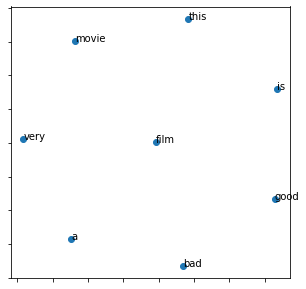

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
vocabs = model.wv.vocab.keys()
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
vectors_tsne = tsne_model.fit_transform(model[vocabs])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
for i, word in enumerate(list(vocabs)):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()

# 【問題5】コーパスの前処理

コーパスの前処理として、特殊文字（!など）やURLの除去、大文字の小文字化といったことを行なってください。また、単語（トークン）はリストで分割してください。

In [37]:
print(len(x_train), len(x_test),len(y_train),len(y_test))
print(type(x_train),type(x_test),type(y_train),type(y_test))
print(x_train[0])
print(x_train[1])

25000 25000 25000 25000
<class 'list'> <class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
Words can't describe how bad this movie is. I can't explain it by writing only. You have too see it for yourself to get at grip of ho

In [38]:
# BeautifulSoupを用いる
def kopa(data):
  after =[]
  for i in range(len(data)):
    #after.append([])
    # URLの除去
    data_new_1 = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "",data[i]) 
    # タグ除去
    data_new_2 = re.sub(r'<[^>]+>', " ",data_new_1)
    # 数字と英字以外除去
    data_new_3 = re.sub(r"[^0-9a-zA-Z ]", "",data_new_2)
    # 小文字に統一
    data_after = data_new_3.lower()
    #print(i)
    #print(data_after)
    after.append(data_after)
    #print(after)
  return after

x_trainとx_testを前処理

In [39]:
X_train_after = kopa(x_train)

In [40]:
X_test_after = kopa(x_test)

確認

In [41]:
print(X_train_after[0])
print(X_train_after[1])
print(X_test_after[0])
print(X_test_after[1])

zero day leads you to think even rethink why two boysyoung men would do what they did  commit mutual suicide via slaughtering their classmates it captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their ownmutual world via coupled destruction  it is not a perfect movie but given what moneytime the filmmaker and actors had  it is a remarkable product in terms of explaining the motives and actions of the two young suicidemurderers it is better than elephant  in terms of being a film that gets under our rationalistic skin it is a far far better film than almost anything you are likely to see   flawed but honest with a terrible honesty
words cant describe how bad this movie is i cant explain it by writing only you have too see it for yourself to get at grip of how horrible a movie really can be not that i recommend you to do that there are so many clichs mistakes and all other negative things you can imag

## 【問題6】Word2Vecの学習

Word2Vecの学習を行なってください。

In [42]:
ans_list = []
for i in range(len(X_train_after)):
  #ans_list.append([])
  word_list = X_train_after[i].split(' ')
  ans_list.append(word_list)

In [43]:
type(ans_list)

list

In [44]:
len(ans_list)

25000

In [45]:
model = Word2Vec(min_count=1, size=100) # 次元数を100に設定
model.build_vocab(ans_list) # 準備
model.train(ans_list, total_examples=model.corpus_count, epochs=model.iter) # 学習

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(22062515, 29221650)

In [47]:
# 確認
model.wv['hand']

array([-2.1359603 ,  0.9583196 ,  0.7413988 ,  0.13293387,  1.8605096 ,
       -1.6601481 ,  1.0047208 ,  0.7113172 , -1.2800347 ,  2.3938928 ,
        0.16878429, -0.9105411 ,  0.38758636, -0.6888046 ,  1.0677651 ,
        0.46741223, -2.7598245 ,  0.57216024,  0.31584546,  0.5521914 ,
        0.20100088,  0.5984734 ,  0.2487375 , -1.9935567 , -0.6744313 ,
       -1.3981931 ,  0.1757946 ,  0.2110907 , -0.58785343, -1.2776468 ,
        0.97017765, -1.1194825 , -2.9304109 , -0.1670613 ,  0.233901  ,
        0.43394384, -0.34326416, -0.06781776,  0.23744291, -0.39793202,
       -1.6483561 , -0.6813967 , -0.2402552 , -0.03637615,  0.06262945,
        0.15779087,  0.637683  , -0.60044867, -1.9257301 ,  2.3358293 ,
       -0.78262544, -0.42822084, -1.2340918 , -0.7249572 ,  0.91832596,
        0.8560755 , -1.7889841 , -0.6180754 , -2.3907678 , -0.0372172 ,
       -0.0888141 ,  1.4603791 , -1.0422497 ,  1.2938216 , -0.21845685,
        1.7148824 , -1.8232405 ,  0.5942235 , -0.556349  , -0.72